# Project Three: Winning the flight game in Decemeber

The project is to predict if an airline that flies out from Boston to Chicago will be delayed in the month of December.


In [1]:
import os
try:
    inputFunc = raw_input
except NameError:
    inputFunc = input

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import numpy as np
 
import seaborn as sns
from statsmodels.formula.api import ols

from sklearn import linear_model
from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from patsy import dmatrices

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import random



# Custom functions

def evaluate(pred, labels_test):
    acc = accuracy_score(pred, labels_test)
    print ("Accuracey: %s"%acc)
    tn, fp, fn, tp = confusion_matrix(labels_test, pred).ravel()

    recall = tp / (tp + fp)
    percision = tp / (tp + fn)
    f1 = (2 / ((1/recall)+(1/percision)))

    print ("")
    print ("True Negatives: %s"%tn)
    print ("False Positives: %s"%fp)
    print ("False Negatives: %s"%fn)
    print ("True Positives: %s"%tp)
    print ("Recall: %s"%recall)
    print ("Precision: %s"%percision)
    print ("F1 Score: %s"%f1)

def plot_bound(Z_val,data,col1,col2,binary):
    # Z-val equals "Yes" value. E.g., "Y" or "1". 
    # data equals df
    # col1 and col2 defines which colums to use from data
    # Plot binary decision boundary. 
    # For this, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    
    x_min = float(data.iloc[:,[col1]].min())-float(data.iloc[:,[col1]].min())*0.10 
    x_max = float(data.iloc[:,[col1]].max()+float(data.iloc[:,[col1]].min())*0.10)
    y_min = 0.0; 
    y_max = float(training.iloc[:,[col2]].max())+float(training.iloc[:,[col2]].max())*0.10
    h_x = (x_max-x_min)/100  # step size in the mesh
    h_y = (y_max-y_min)/100  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h_x), np.arange(y_min, y_max, h_y))
    if binary == 1:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])   
        Z = np.where(Z=="Y",1,0)
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.pcolormesh(xx, yy, Z)
    plt.show()

## Data 

Here I'm loading the [data](http://www.codingthelaw.org/Fall_2017/work/shentail/p3/data coding.csv) which i retrieved from the [Bureau of Transporation Statistics](https://www.transtats.bts.gov/) under the Department of Transportation. 
I first picked the data set that I wanted through the online database. The website isolated all flights to and from Boston. I then use Excel to pick out those flying from Boston to Chicago. Then i further picked out those in December. In order to have a better prediction, I also added another year which adds to the amount of data I have. 
The data include flights flying out of Boston to Chicago in the month of December 2015 and December 2016. The airline that flown are coded into numbers. [Here](http://www.codingthelaw.org/Fall_2017/work/shentail/p3/L_AIRLINE_ID.csv) is the airline ID code. Then there is a column for delay over 15 minutes where 1 = there is a delay and 0 = there is no delay or delay was not over 15minutes. Then there is a third column where the flight was cancelled. 


In [6]:
# Load and peek at your data. Change the file name as needed. 
raw_data_df = pd.read_csv('data coding.csv', parse_dates=[0]) 
raw_data_df.head()

,AIRLINE_ID,Delay over 15,CANCELLED
0,19805,0.0,0
1,19805,0.0,0
2,19805,1.0,0
3,19805,0.0,0
4,19805,0.0,0


In [7]:
# You can explore unique entires by stating the column and using .unique() like this:
print(raw_data_df["AIRLINE_ID"].unique())
print(raw_data_df["Delay over 15"].unique())
print(raw_data_df["CANCELLED"].unique())

['19805' '20409' '20304' '19977' '19393']
[  0.   1.  nan]
[0 1]


In order to differentiate the airlines, we need to split up the airlines into different columns.  I followed the [airline ID](http://www.codingthelaw.org/Fall_2017/work/shentail/p3/L_AIRLINE_ID.csv) and created the following columns.

19805=AA American,
20409=B6 Jetblue,
20304=OO Skywest,
19977=UA United,
19393=WN Southwest 

In [8]:
raw_data_df["American Airlines"] = 0
raw_data_df["Jetblue Airways"] = 0
raw_data_df["SkyWest Airlines"] = 0
raw_data_df["United Air Lines"] = 0
raw_data_df["Southwest Airlines"] = 0
raw_data_df.head()

,AIRLINE_ID,Delay over 15,CANCELLED,American Airlines,Jetblue Airways,SkyWest Airlines,United Air Lines,Southwest Airlines
0,19805,0.0,0,0,0,0,0,0
1,19805,0.0,0,0,0,0,0,0
2,19805,1.0,0,0,0,0,0,0
3,19805,0.0,0,0,0,0,0,0
4,19805,0.0,0,0,0,0,0,0


I can find out how many delays over 15min are there in the whole data set as well. 

In [9]:
print("Size of entire table: %s "%len(raw_data_df))
print("Size of entires matching filter: %s "%len(raw_data_df[raw_data_df["Delay over 15"]==1]))

Size of entire table: 1234 
Size of entires matching filter: 181 


So there are a total of 1234 flights in the month of December 2015 and 2016. Out of the 1234 flights, 181 of them were delayed for over 15min.  Since i am only looking at the delays, I do not need the 'cancelled' column. 

In [10]:
# You can remove unwanted colums like so
# for a single column
processed_data_df = raw_data_df
processed_data_df = processed_data_df.drop('CANCELLED', 1)
processed_data_df.head()

,AIRLINE_ID,Delay over 15,American Airlines,Jetblue Airways,SkyWest Airlines,United Air Lines,Southwest Airlines
0,19805,0.0,0,0,0,0,0
1,19805,0.0,0,0,0,0,0
2,19805,1.0,0,0,0,0,0
3,19805,0.0,0,0,0,0,0
4,19805,0.0,0,0,0,0,0


There are also NaN in the column on Delayed over 15. Those are empty becuse the flights were cancelled. These flights should not be counted in the data set. Therefore I have to remove the NaN data.

In [11]:
# for the special case of when a value is NaN, you can filter based on the value not being null (i.e., empty)
processed_data_df = processed_data_df[pd.notnull(processed_data_df["Delay over 15"])]
print("Size of entire table: %s "%len(processed_data_df)) 
processed_data_df.head()
# this gets rid of a few rows from 1234 to 1200

Size of entire table: 1200 


,AIRLINE_ID,Delay over 15,American Airlines,Jetblue Airways,SkyWest Airlines,United Air Lines,Southwest Airlines
0,19805,0.0,0,0,0,0,0
1,19805,0.0,0,0,0,0,0
2,19805,1.0,0,0,0,0,0
3,19805,0.0,0,0,0,0,0
4,19805,0.0,0,0,0,0,0


In [12]:
# You can replace values in a column based on logic like so
processed_data_df.loc[processed_data_df['AIRLINE_ID'] =='19805', 'American Airlines'] = 1
processed_data_df.loc[processed_data_df['AIRLINE_ID'] =='20409', 'Jetblue Airways'] = 1
processed_data_df.loc[processed_data_df['AIRLINE_ID'] =='20304', 'SkyWest Airlines'] = 1
processed_data_df.loc[processed_data_df['AIRLINE_ID'] =='19977', 'United Air Lines'] = 1
processed_data_df.loc[processed_data_df['AIRLINE_ID'] =='19393', 'Southwest Airlines'] = 1
processed_data_df.head()

,AIRLINE_ID,Delay over 15,American Airlines,Jetblue Airways,SkyWest Airlines,United Air Lines,Southwest Airlines
0,19805,0.0,1,0,0,0,0
1,19805,0.0,1,0,0,0,0
2,19805,1.0,1,0,0,0,0
3,19805,0.0,1,0,0,0,0
4,19805,0.0,1,0,0,0,0


Since i transferred all the data of Airline_ID to the table, i do not need that column anymore. 

In [13]:
# You can remove unwanted colums like so
processed_data_df = processed_data_df.drop(['AIRLINE_ID'], 1)
processed_data_df.head()

,Delay over 15,American Airlines,Jetblue Airways,SkyWest Airlines,United Air Lines,Southwest Airlines
0,0.0,1,0,0,0,0
1,0.0,1,0,0,0,0
2,1.0,1,0,0,0,0
3,0.0,1,0,0,0,0
4,0.0,1,0,0,0,0


In [17]:
# This set will be for classifiers where the target is a class.
delay_class_df = processed_data_df[[
                               'Delay over 15', 
                               'American Airlines', 
                               'United Air Lines'
                               ]].copy()
delay_class_df.head()

,Delay over 15,American Airlines,United Air Lines
0,0.0,1,0
1,0.0,1,0
2,1.0,1,0
3,0.0,1,0
4,0.0,1,0


## Taining and Validation: delay_class_df


Percentage of 1s: 0.15083333333333335



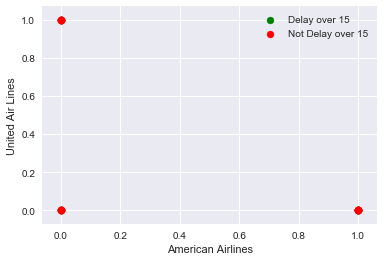

In [18]:
data = delay_class_df
holdout = data.sample(frac=0.05)
training = data.loc[~data.index.isin(holdout.index)]

# Define the target (y) and feature(s) (X)
features_train = training.drop("Delay over 15", axis=1).as_matrix(columns=None)
labels_train = training["Delay over 15"].as_matrix(columns=None)

features_test = holdout.drop("Delay over 15", axis=1).as_matrix(columns=None)
labels_test = holdout["Delay over 15"].as_matrix(columns=None)

# What percentage of the time is target Y?
print("Percentage of 1s: %s\n"%(len(data[data["Delay over 15"]== 1 ])/len(data)))

#### initial visualization
feature_1_no = [features_test[ii][0] for ii in range(0, len(features_test)) if labels_test[ii]== 0]
feature_2_no = [features_test[ii][1] for ii in range(0, len(features_test)) if labels_test[ii]== 0]
feature_1_yes = [features_test[ii][0] for ii in range(0, len(features_test)) if labels_test[ii]== 1]
feature_2_yes = [features_test[ii][1] for ii in range(0, len(features_test)) if labels_test[ii]== 1]
plt.scatter(feature_1_yes, feature_2_yes, color = "g", label="Delay over 15")
plt.scatter(feature_1_no, feature_2_no, color = "r", label="Not Delay over 15")
plt.legend()
plt.xlabel("American Airlines")
plt.ylabel("United Air Lines")
plt.show()


In [19]:
# Logistic Regression
model = LogisticRegression(fit_intercept = False, C = 1e9)
clf = model.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("Logistic Regression")
evaluate(pred, labels_test)  
#plot_bound("Y",holdout,1,2,0)


# Test some spot
x_test = 70
y_test = 160000
print("")
print(clf.predict([[x_test,y_test]])[0])
print(clf.predict_proba([[x_test,y_test]])[0][1])
print("")

from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=40)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("\nDecision Tree")
evaluate(pred, labels_test)
#plot_bound("Y",holdout,1,2,0)



from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("Random Forest")
evaluate(pred, labels_test)  
#plot_bound("Y",holdout,1,2,0)


from sklearn.svm import SVC
clf = SVC(kernel="rbf",probability=True)
clf = clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
print("SVM")
evaluate(pred, labels_test)  
#plot_bound("Y",holdout,1,2,0) # plot doesn't work with SVM

Logistic Regression
Accuracey: 0.866666666667

True Negatives: 52
False Positives: 0
False Negatives: 8
True Positives: 0
Recall: nan
Precision: 0.0
F1 Score: nan

0.0
0.0


Decision Tree
Accuracey: 0.866666666667

True Negatives: 52
False Positives: 0
False Negatives: 8
True Positives: 0
Recall: nan
Precision: 0.0
F1 Score: nan
Random Forest
Accuracey: 0.866666666667

True Negatives: 52
False Positives: 0
False Negatives: 8
True Positives: 0
Recall: nan
Precision: 0.0
F1 Score: nan
SVM
Accuracey: 0.866666666667

True Negatives: 52
False Positives: 0
False Negatives: 8
True Positives: 0
Recall: nan
Precision: 0.0
F1 Score: nan


/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars
/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars


## Result analysis

Based on the result, the accuracy was about 83%. This seems to say that the prediction was pretty accurate. If you look further into the results though, you can see the flaw in this prediction model. 

First there are no positives in the model. The model is basically saying that there are no delays at all. But from the data, there are about 6.7% of flights delayed in the month of December 2015,2016, and there is bound to be a delay during the cold snowy month from Boston to Chicago. 
The high negative predictive values also conform to the result, which shows that there is a high probablity (FN:9, TN: 51) an airline you pick would not be delayed.

Therefore even though the accuracy is high, the model was shown not to be very good at predicting if a certain airline flying to Chicago will be delayed. To create a better model, maybe there could be an additional row of other months which can change the prediction to which month is better suited to fly without delays. 
